以下部分是数值课作业P3-P5的内容，出于jupyter的特性，将绘图的解释以及代码写在同一个文档之中，以便描述。

# 数值课 P3
抄自matlab脚本，使用与matlab绘图风格相近的matplotlib进行绘图

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#construct list
l_exact = [];l_1st   = [];l_2nd   = [];l_4th   = [];l_x     = [];l_dx    = []

In [3]:
N=np.arange(3,14)
N=np.power(2,N)
L=3.; #Length of domain
m=1; #counter for number of grid sizes to plot

# N=[4,8,16]
for nn in N:
    deltax = L/nn; #Grid spacing
    x = np.linspace(0,L,int(nn)+1); #define x, grid
    # nx=length(x); #number of points in grid
    nx = np.size(x)
    f = np.sin(5*x); #function to be differentiated
    dfdx_exact = 5*np.cos(5*x); #exact (analytical) derivative
    dfdx_1st = np.NaN*np.ones(np.size(dfdx_exact));
    dfdx_2nd = np.NaN*np.ones(np.size(dfdx_exact));
    dfdx_4th = np.NaN*np.ones(np.size(dfdx_exact));

    
    for i in range(3,nx-2): #Notice the limits here
        dfdx_1st[i] =  (f[i+1]-f[i])/deltax; #first order forward
        dfdx_2nd[i] =  (f[i+1]-f[i-1])/deltax/2; #second order central
        dfdx_4th[i] =  (f[i-2]-8*f[i-1]+8*f[i+1]-f[i+2])/12./deltax; #fourth order central
    
    l_x.append(x)
    l_exact.append(dfdx_exact)
    l_1st.append(dfdx_1st)
    l_2nd.append(dfdx_2nd)
    l_4th.append(dfdx_4th)
    l_dx.append(deltax)

### 下面进行差分结果绘图，label上的数字为对应的格点数N
<b>绘制N从4-64的结果，标注在图注的上方

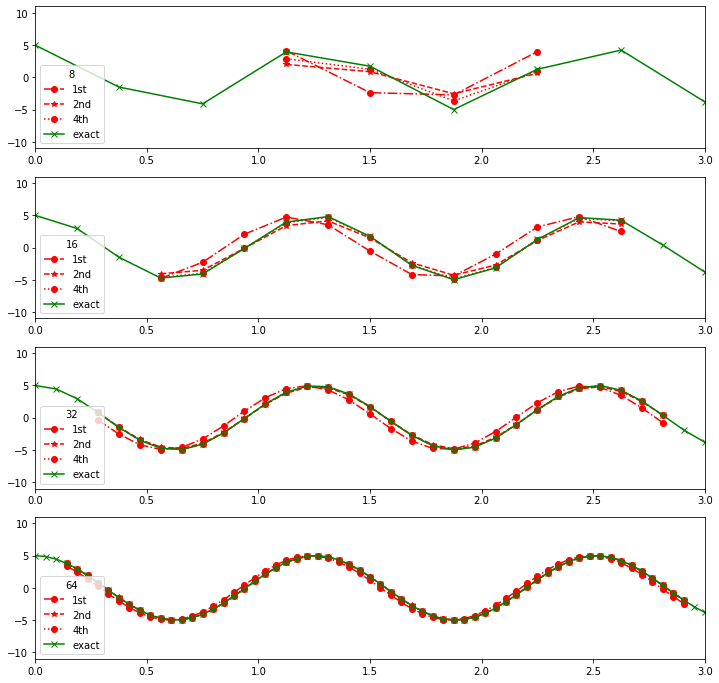

In [4]:
plot_dim = 4

fig,ax = plt.subplots(4,figsize=(12,12))

for nn in range(0,plot_dim):
    custom_xlim = (0, 3)
    custom_ylim = (-11, 11)
    # Setting the values for all axes.
    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
    ax[nn].plot(l_x[nn],l_1st[nn],'-.or',label='1st')
    ax[nn].plot(l_x[nn],l_2nd[nn],'--*r',label='2nd')
    ax[nn].plot(l_x[nn],l_4th[nn],':or',label='4th')
    ax[nn].plot(l_x[nn],l_exact[nn],'-xg',label='exact')
    ax[nn].legend(title = N[nn],loc='lower left')
#     ax[nn].legend(')

### 对图的讨论：
<br>  随着格点数的加密，差分格式都逐渐逼近绿色的真实值。
<br>  N=16时，2nd和4th相差较小，1st格式偏差大，相对真实值总是落后一定位相。

### 检验 x=1.5 处格点的error

In [5]:
midpoint = np.zeros(np.size(N))
error = np.zeros([np.size(N),3]) # row 为不同的midpoint col为 1st 2nd 4th误差  [errors in Ns x (1st,2nd,4th)]
for i in range(np.size(N)):
#     print(i)
    midpoint = int(N[i]/2)
#     print(midpoint)
    real = l_exact[i][midpoint]
#     print(real)
    error[i][0] = abs(real - l_1st[i][int(midpoint)])
    error[i][1] = abs(real - l_2nd[i][int(midpoint)])
    error[i][2] = abs(real - l_4th[i][int(midpoint)])
#     print(midpoint)
#     print(l_exact[i][int(midpoint)])


## 下面进行log-log绘图 比较斜率

In [6]:
slope = np.diff(np.log(error[:][:]),axis=0,n=1)

In [7]:
for i in range(3):
    slope[:,i] = slope[:,i]/np.diff(np.log(l_dx))

Text(0, 0.5, 'error')

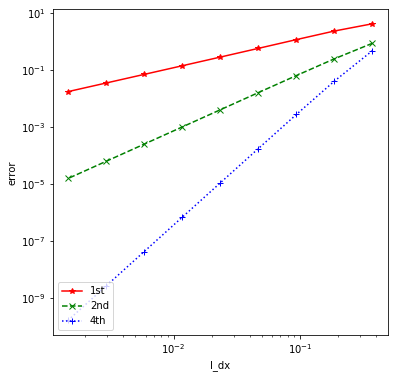

In [8]:
fig,ax = plt.subplots(1,figsize=(6,6))
# custom_xlim = (-1, 1)
# custom_ylim = (-4, 4)
# Setting the values for all axes.

# plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
ax.loglog(l_dx[:9], error[0:9,0],'-*r', label='1st')
ax.loglog(l_dx[:9], error[0:9,1], '--xg', label='2nd')
ax.loglog(l_dx[:9], error[0:9,2], '+:b', label='4th')
# ax.plot(np.log(l_dx[:7]),slope[:,1],'--xg',label='2nd')
# ax.plot(l_dx[:7],slope[:,2],'+:b',label='4th')
ax.set_xscale("log", basex=10)
ax.set_yscale("log", basey=10)
ax.legend(loc='lower left')
plt.xlabel('l_dx')
plt.ylabel('error')
#     ax[nn].legend(')

### 对斜率的讨论
<br>  随着格距的减小，l_dx从左向右来看，在log-log图中误差和格距呈线性关系；并且误差减小的斜率随格式的精度减小而显著增加，即四阶精度的格式相较二阶和一阶精度误差减小更加显著（当然二阶也相较一阶减少误差更加显著）。
<br>  在最密的格点的计算结果上，三种格式的误差出现了显著的数量级的差异，即四阶精度(1e-9)高二阶(1e-5)四个数量级，二阶高一阶精度(1e-1)约4个数量级。

# 数值课P4

构造taylor table解线性方程组，得到四个点相应的系数
<br>taylor展开参考:https://github.com/dongli/ipynb-files/blob/master/taylor_diff_formula.ipynb

In [1]:
from sympy import *
from pprint import pprint
h = symbols('Delta'); f = Function('f')
def taylor(f, x, n):
	if x == 0:
		return [1 if i == 0 else 0 for i in range(n+1)]
	else:
		return [list(x.as_coefficients_dict().values())[0] for x in f(x).series(x, x0=0, n=n+1).as_ordered_terms()][:-1]

In [2]:
# 1st order difference formula
print('construct matrix:')
M = Matrix([
	taylor(f, -1 * h, 3), # xj -  delta
 	taylor(f,      0, 3), # xj 
    taylor(f,  1 * h, 3), # xj +  delta
    taylor(f,  2 * h, 3)  # xj + 2delta
]).transpose()
pprint(M)
w = list(M.inv() * Matrix([0, -1, 0, 0]))

print("result:")
pprint(w)


construct matrix:
Matrix([
[   1, 1,   1,   1],
[  -1, 0,   1,   2],
[ 1/2, 0, 1/2,   2],
[-1/6, 0, 1/6, 4/3]])
result:
[1/3, 1/2, -1, 1/6]


# 数值课P5
<br>remark:数据初始化，生成三对角矩阵，求解，都用函数进行；
<br>后使用ipyhon命令timeit计算平均运行时间，用python的cpu计时器计算大量计算的时间开销，并绘图进行比较

In [14]:
import numpy as np
N = 21 # GRID POINTS

按照P5要求进行变量初始化的函数，生成三对角数组

In [15]:
def init_p5(N):
    # initial P5 data
    row_a, row_b, row_c, row_d,ff = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N),np.zeros(N)
    matrix_check = np.zeros([N,N])
    # del(x)
    x = np.zeros(N)
    
    # a from row 2 to row N
    row_a[1:N-1] = 1
    row_a[N-1] = -1
    # b from row 2 to row N
    row_b[1:N-1] = -2 
    row_b[N-1] = 1
    row_b[0]   = 1
    # c from row 1 to row N-1
    row_c[1:N-1] = 1
    # row_c[0] = 1
    # d intintal data
    row_d[0] = 2;row_d[1] = 3
    # for checking
    d_check = row_d
    return [row_a,row_b,row_c,row_d,ff,matrix_check,d_check]

变量初始化

In [16]:
[row_a,row_b,row_c,row_d,ff,matrix_check,d_check] = init_p5(N)

通过三对角的数组构造三对角矩阵，用于进行矩阵求逆，计算时间

In [17]:
def construct_matrix(matrix,row_a,row_b,row_c):
    # 通过对角线数组a,b,c构造矩阵
    N = np.size(row_a)
    for i in range(2,N):
        #     print(i)
        #     print(row_a[i-1])
        matrix_check[i-1,i-2] = row_a[i-1]
        matrix_check[i-1,i-1] = row_b[i-1]
        matrix_check[i-1,i]   = row_c[i-1]
        # start and end
        matrix_check[0,0] = row_b[0]
        matrix_check[N-1,N-2] = row_a[N-1]
        matrix_check[N-1,N-1] = row_b[N-1]
    
    return matrix

In [18]:
matrix_check = construct_matrix(matrix_check,row_a,row_b,row_c)

Thomas方法求解三对角矩阵

In [19]:
# Thomas_tri 求解三对角矩阵,ff及为输出各个格点结果
def Thomas_tri(row_a,row_b,row_c,row_d,ff):
    # count matrix
    N = np.size(ff)
    a,b,c,d = np.copy([row_a,row_b,row_c,row_d])
    for i in range(1,N):
        b[i] = b[i] - a[i]*c[i-1]/b[i-1]
        d[i] = d[i] - a[i]*d[i-1]/b[i-1]
        
    ff[N-1] = d[N-1] / b[N-1]
    
    for i in range(N-2,-1,-1):
        ff[i] = (d[i]-c[i]*ff[i+1])/b[i]
    return ff

计算结果：

In [20]:
Thomas_tri(row_a,row_b,row_c,row_d,ff)

array([ 2., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1.])

## 用矩阵的方法计算来转置比较时间

因为赋值机制的问题，在格点数目相对较多的时候才非常显著，时间差异的话，下面将N改成400就比较明显

更改格点数目到400

In [21]:
[row_a,row_b,row_c,row_d,ff,matrix_check,d_check] = init_p5(400)
matrix_check = construct_matrix(matrix_check,row_a,row_b,row_c)

通过逆矩阵方法求解三对角：

In [22]:
%timeit np.dot(np.linalg.inv(matrix_check),d_check)

9.84 ms ± 21.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


通过托马斯方法求解三对角：

In [23]:
%timeit Thomas_tri(row_a,row_b,row_c,row_d,ff)

1.14 ms ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


result：可以看出Thomas方法的计算时间和传统的变形为逆矩阵的方法相比，减少到约1/8

## 从10-2000个格点进行尝试两种方法时间开销，并进行绘图，说明时间开销随格点数的变化

In [24]:
# 计时的模块, 100 runs
import time
default_timer = time.time
n_testtime    =  np.arange(10,2000,10,dtype='int')#np.linspace(10,100,1) # grids point number to test
time_inv      = np.zeros(np.size(n_testtime))
time_thomas   = np.zeros(np.size(n_testtime))
tick = 0
for j in n_testtime:
#initial n grids
    [row_a,row_b,row_c,row_d,ff,matrix_check,d_check] = init_p5(int(j))
    matrix_check = construct_matrix(matrix_check,row_a,row_b,row_c)
    
    ts = default_timer()
    for i in range(10):
        np.dot(np.linalg.inv(matrix_check),d_check)
    te = default_timer()
    time_inv[tick] = te - ts
    
    tst = default_timer()
    for i in range(10):
        Thomas_tri(row_a,row_b,row_c,row_d,ff)
    tet = default_timer()
    time_thomas[tick] = tet - tst
    
    
    tick = tick + 1
# time_check

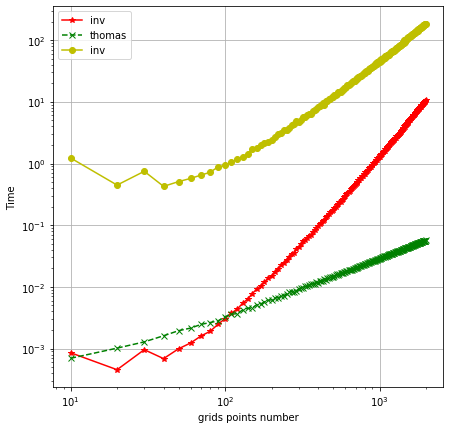

In [28]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
# custom_xlim = (-1, 1)
# custom_ylim = (-4, 4)
# Setting the values for all axes.
# plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)

ax.loglog(n_testtime, time_inv,'-*r', label='inv')
ax.loglog(n_testtime, time_thomas, '--xg', label='thomas')
ax.loglog(n_testtime, time_inv/time_thomas,'-oy', label='inv')
ax.set_xscale("log", basex=10)
ax.set_yscale("log", basey=10)
ax.legend(loc='upper left')
ax.set_xlabel('grids points number')
ax.set_ylabel('Time')
ax.grid()

### 时间开销图的解释：
<br>上图中的时间开销在格点较少的时候，两种方法(红色星号和绿色×号)的运行时间的区别并未太明显（因为自己编写的Thomas方法效率很低，有很多赋值的内存开销）
<br>在log-log图上两种方法时间开销的斜率都呈线性增长，在格点数增加到10^3以上后，转置方法的计算开销增长（即斜率）高于Thomas方法10^2左右
<br>最上方的黄色圆点是不同格点数目下，转置和Thomas方法时间开销比例，在10^3格点时，转置已经高出Thomas近百倍，并且还在呈指数级增长。